In [1]:
from math import pi
import numpy
%matplotlib inline
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
def plot_3D(x,y,u):    
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,u[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$u$')
    ax.view_init(30,45)

In [3]:
def poisson_exact(ni,nj,n):
    x=numpy.linspace(0,1,ni)
    y=numpy.linspace(0,1,nj)
    X,Y=numpy.meshgrid(x,y)
    u_ex=numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    plot_3D(x,y,u_ex)
    return u_ex

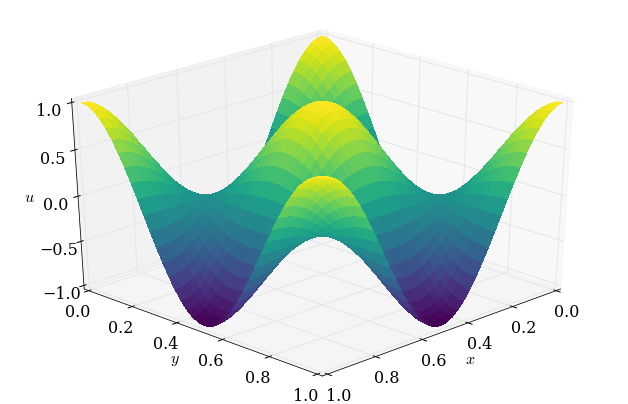

In [4]:
u_exact1=poisson_exact(41,41,1)

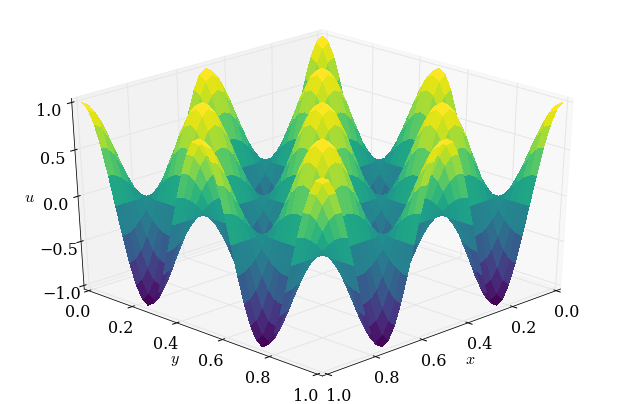

In [5]:
u_exact2=poisson_exact(41,41,2)

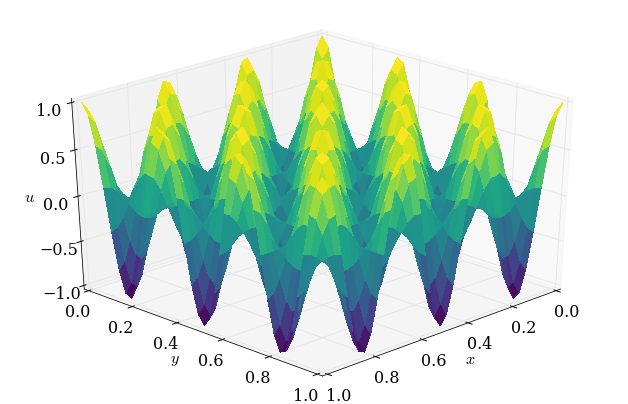

In [6]:
u_exact10=poisson_exact(41,41,3)

In [7]:
def poisson_initial(ni,nj):
    u0=numpy.random.random((nj,ni))
    x=numpy.linspace(0,1,ni)
    y=numpy.linspace(0,1,nj)
    plot_3D(x,y,u0)
    return u0

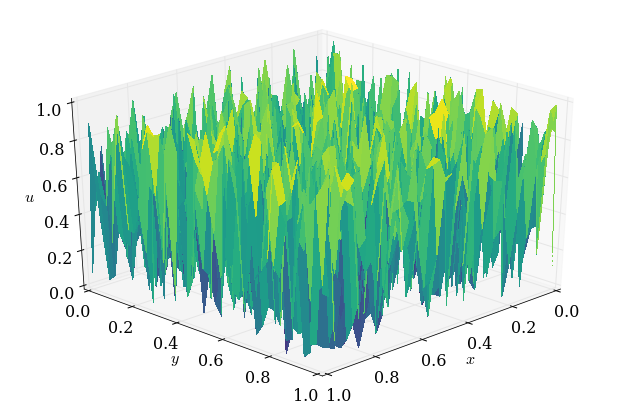

In [8]:
u0=poisson_initial(41,41)

In [9]:
def jacobi(u0,ni,nj,n,N):
    u=u0.copy()
    x=numpy.linspace(0,1,ni)
    y=numpy.linspace(0,1,nj)
    dx=1./(ni-1)
    dy=1./(nj-1)
    X,Y=numpy.meshgrid(x,y)
    f=-2*(2*pi*n)**2*numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    u_ex=numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    u[0,:]=u_ex[0,:]
    u[-1,:]=u[-2,:]
    u[:,0]=u[:,1]
    u[:,-1]=u[:,-2]
    iterations=0
    dif=numpy.zeros((nj,ni))
    err=numpy.zeros((nj,ni))
    res=numpy.zeros((nj,ni))
    for iterations in range(N):
        uold=u.copy()
        u[1:-1,1:-1]=1/(2*(dx**2+dy**2))*((uold[1:-1,2:]+uold[1:-1,:-2])*dy**2+\
                     (uold[2:,1:-1]+uold[:-2,1:-1])*dx**2-f[1:-1,1:-1]*dx**2*dy**2)
        #for j in range(1,nj-1):
            #for i in range(1,ni-1):
                #u[j,i]=1./(2*(dx**2+dy**2))*((uold[j,i+1]+uold[j,i-1])*dy**2+\
                       #(uold[j+1,i]+uold[j-1,i])*dx**2-f[j,i]*dx**2*dy**2)
        u[0,:]=u_ex[0,:]
        u[-1,:]=u[-2,:]
        u[:,0]=u[:,1]
        u[:,-1]=u[:,-2]
        iterations+=1
    
    for j in range(nj):
        for i in range(ni):
            dif[j,i]=numpy.abs(u[j,i]-uold[j,i])
            err[j,i]=numpy.abs(u[j,i]-u_ex[j,i])
    for j in range(1,nj-1):
        for i in range(1,ni-1):
            res[j,i]=numpy.abs(f[j,i]-(u[j,i-1]-2*u[j,i]+u[j,i+1])/dx**2-\
                           (u[j-1,i]-2*u[j,i]+u[j+1,i])/dy**2)
    dif_sum=numpy.sum(dif)
    err_sum=numpy.sum(err)
    res_sum=numpy.sum(res)
    #dif=numpy.max(numpy.abs(u-uold))
    #err=numpy.max(numpy.abs(u-u_ex))
    #res=numpy.max(numpy.abs(f[1:-1,1:-1]-\
                        #(u[1:-1,:-2]-2*u[1:-1,1:-1]+u[1:-1,2:])/dy**2-\
                        #(u[:-2,1:-1]-2*u[1:-1,1:-1]+u[2:,1:-1])/dx**2))
    return u,x,y,dif_sum,err_sum,res_sum

dif_jacobi1=0.17927314495682362
err_jacobi1=498.82624841354664
res_jacobi1=1055.4240675560163


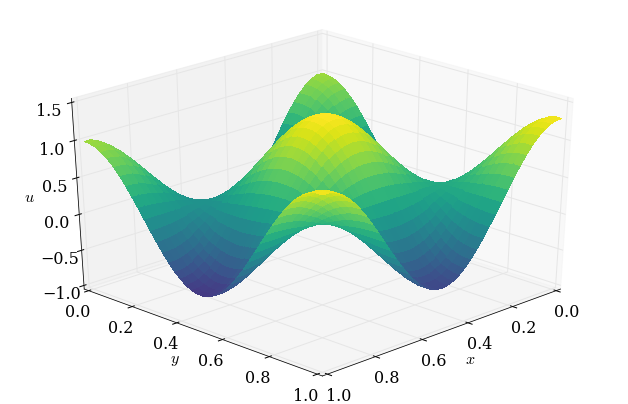

In [10]:
u_jac1,x_jac1,y_jac1,dif_jac1,err_jac1,res_jac1=jacobi(u0,41,41,1,1000)
plot_3D(x_jac1,y_jac1,u_jac1)
print('dif_jacobi1={}'.format(dif_jac1))
print('err_jacobi1={}'.format(err_jac1))
print('res_jacobi1={}'.format(res_jac1))

dif_jacobi2=0.1643736641428284
err_jacobi2=522.7995108374889
res_jacobi2=969.8701795717902


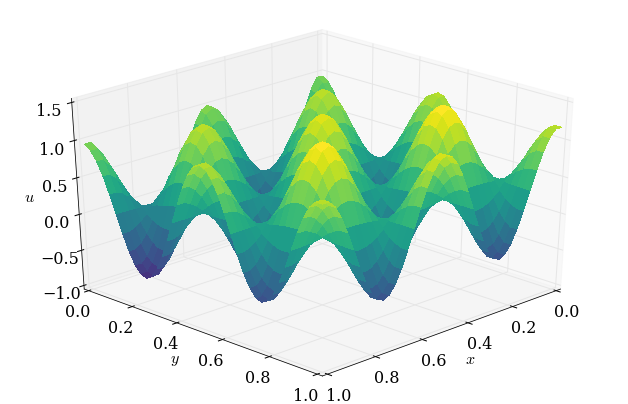

In [11]:
u_jac2,x_jac2,y_jac2,dif_jac2,err_jac2,res_jac2=jacobi(u0,41,41,2,1000)
plot_3D(x_jac2,y_jac2,u_jac2)
print('dif_jacobi2={}'.format(dif_jac2))
print('err_jacobi2={}'.format(err_jac2))
print('res_jacobi2={}'.format(res_jac2))

dif_jacobi3=0.13930729265808312
err_jacobi3=558.3153208444554
res_jacobi3=825.3119943328747


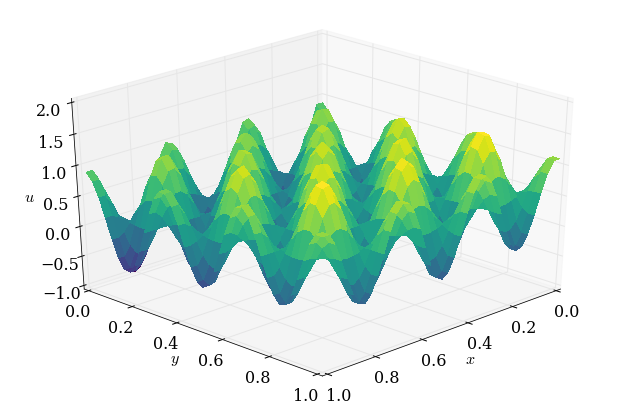

In [12]:
u_jac3,x_jac3,y_jac3,dif_jac3,err_jac3,res_jac3=jacobi(u0,41,41,3,1000)
plot_3D(x_jac3,y_jac3,u_jac3)
print('dif_jacobi3={}'.format(dif_jac3))
print('err_jacobi3={}'.format(err_jac3))
print('res_jacobi3={}'.format(res_jac3))

In [13]:
def SOR(u0,ni,nj,n,N,omega):
    u=u0.copy()
    x=numpy.linspace(0,1,ni)
    y=numpy.linspace(0,1,nj)
    dx=1./(ni-1)
    dy=1./(nj-1)
    X,Y=numpy.meshgrid(x,y)
    f=-2*(2*pi*n)**2*numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    u_ex=numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    u[0,:]=u_ex[0,:]
    u[-1,:]=u[-2,:]
    u[:,0]=u[:,1]
    u[:,-1]=u[:,-2]
    dif=numpy.zeros((nj,ni))
    err=numpy.zeros((nj,ni))
    res=numpy.zeros((nj,ni))
    iterations=0
    for iterations in range(N):
        uold=u.copy()
        for j in range(1,nj-1):
            for i in range(1,ni-1):
                u[j,i]=omega/(2*(dx**2+dy**2))*((u[j,i-1]+u[j,i+1])*dy**2+\
                       (u[j-1,i]+u[j+1,i])*dx**2-f[j,i]*dx**2*dy**2)+\
                       (1-omega)*u[j,i]
        u[0,:]=u_ex[0,:]
        u[-1,:]=u[-2,:]
        u[:,0]=u[:,1]
        u[:,-1]=u[:,-2]
        iterations+=1
    
    for j in range(nj):
        for i in range(ni):
            dif[j,i]=numpy.abs(u[j,i]-uold[j,i])
            err[j,i]=numpy.abs(u[j,i]-u_ex[j,i])
    for j in range(1,nj-1):
        for i in range(1,ni-1):
            res[j,i]=numpy.abs(f[j,i]-(u[j,i-1]-2*u[j,i]+u[j,i+1])/dx**2-\
                           (u[j-1,i]-2*u[j,i]+u[j+1,i])/dy**2)
    dif_sum=numpy.sum(dif)
    err_sum=numpy.sum(err)
    res_sum=numpy.sum(res)
    return u,x,y,dif_sum,err_sum,res_sum

dif_SOR1=0.15162746683968303
err_SOR1=132.86255301837434
res_SOR1=161.9713568494733


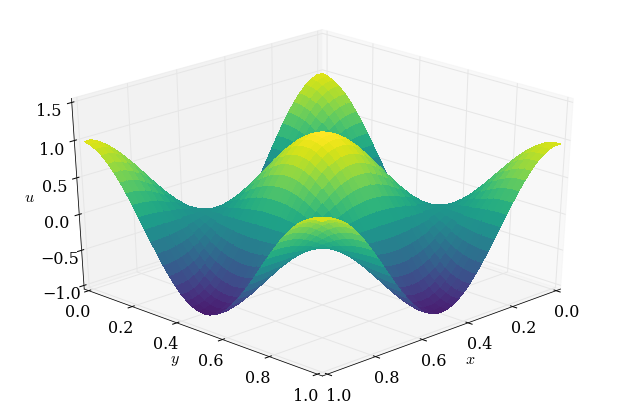

In [15]:
u_SOR1,x_SOR1,y_SOR1,dif_SOR1,err_SOR1,res_SOR1=SOR(u0,41,41,1,1000,1.5)
plot_3D(x_SOR1,y_SOR1,u_SOR1)
print('dif_SOR1={}'.format(dif_SOR1))
print('err_SOR1={}'.format(err_SOR1))
print('res_SOR1={}'.format(res_SOR1))

dif_SOR2=0.13526776932328746
err_SOR2=192.22619047568543
res_SOR2=144.4955331202304


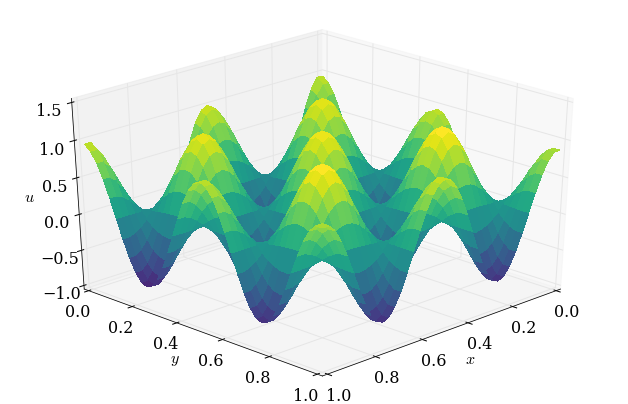

In [16]:
u_SOR2,x_SOR2,y_SOR2,dif_SOR2,err_SOR2,res_SOR2=SOR(u0,41,41,2,1000,1.5)
plot_3D(x_SOR2,y_SOR2,u_SOR2)
print('dif_SOR2={}'.format(dif_SOR2))
print('err_SOR2={}'.format(err_SOR2))
print('res_SOR2={}'.format(res_SOR2))

dif_SOR3=0.10781997336199073
err_SOR3=289.0428857118901
res_SOR3=115.17522578850827


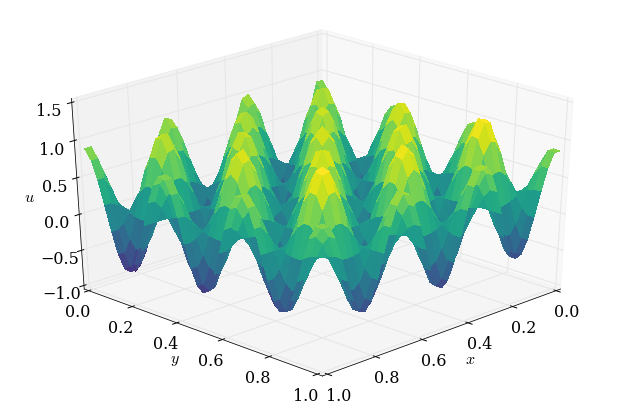

In [17]:
u_SOR3,x_SOR3,y_SOR3,dif_SOR3,err_SOR3,res_SOR3=SOR(u0,41,41,3,1000,1.5)
plot_3D(x_SOR3,y_SOR3,u_SOR3)
print('dif_SOR3={}'.format(dif_SOR3))
print('err_SOR3={}'.format(err_SOR3))
print('res_SOR3={}'.format(res_SOR3))